# Spring's constant measuring

TODO:
- put axis labels

## Importing libraries

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
import os
import math

## Load data

The following code creates a table (dict) with entries that have:
- as key, the name of the file from which the data is read
- as value, the DataFrame returned by pandas when reading that file

Getting data from this table involves using the file from which the data is read as key and then parsing the columns of the corresponding DataFrame.

e.g.:

```
masses_measurements = datasets['misure_masse']
used_objects = masses_measurements[masses_measurements.columns[0]]
masses = masses_measurements[masses_measurements.columns[1]]
```

In [142]:
# collect filenames of exported data

data_dir = "./data"

csv_data = []
excel_data = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        current_file_path = os.path.join(root, file).replace(
            "\\", "/"
        )  # fix the unbearably frustrating flaws of the wanna-be OS... "Windows"
        if "xlsx" in file:
            excel_data.append(current_file_path)
        elif "csv" in file:
            csv_data.append(current_file_path)
    break  # stop at first recursion level: only ./data

print(f"CSV:\n{csv_data}\nEXCEL:\n{excel_data}")

CSV:
['./data/sonar_non-pretensionata_statico.csv', './data/sonar_pretensionata_statico.csv', './data/sonar_non-pretensionata_dinamico.csv', './data/sonar_pretensionata_dinamico.csv']
EXCEL:
['./data/masse_sonar_non-pretensionata_statico.xlsx', './data/calibro_pretensionata_statico.xlsx', './data/masse_sonar_non-pretensionata_dinamico.xlsx', './data/masse_sonar_pretensionata_dinamico.xlsx', './data/misure_masse.xlsx', './data/calibro_non-pretensionata_statico.xlsx', './data/masse_sonar_pretensionata_statico.xlsx']


In [143]:
def read_csv(filename: str):
    data = pd.read_csv(filename, sep=";").replace(",", ".", regex=True)

    data.dropna(inplace=True)
    data.drop(
        index=data.index[0], axis=0, inplace=True
    )  # instrument error causes first value to be nonsensical

    for col in data.columns:
        data[col] = data[col].apply(pd.to_numeric)

    return data


def read_excel(filename: str):
    data = pd.read_excel(filename)
    return data


datasets = dict()

for file in csv_data + excel_data:
    key = os.path.basename(file).split(".")[0]
    if "csv" in file:
        datasets[key] = read_csv(file)
    elif "xlsx" in file:
        datasets[key] = read_excel(file)

print(datasets.keys())

for k in datasets.keys():
    print(f"\nkey: {k}")
    datasets[k].info()

dict_keys(['sonar_non-pretensionata_statico', 'sonar_pretensionata_statico', 'sonar_non-pretensionata_dinamico', 'sonar_pretensionata_dinamico', 'masse_sonar_non-pretensionata_statico', 'calibro_pretensionata_statico', 'masse_sonar_non-pretensionata_dinamico', 'masse_sonar_pretensionata_dinamico', 'misure_masse', 'calibro_non-pretensionata_statico', 'masse_sonar_pretensionata_statico'])

key: sonar_non-pretensionata_statico
<class 'pandas.core.frame.DataFrame'>
Index: 1027 entries, 1 to 1027
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Position (mm) Run #1  1027 non-null   float64
 1   Position (mm) Run #2  1027 non-null   float64
 2   Position (mm) Run #3  1027 non-null   float64
 3   Position (mm) Run #4  1027 non-null   float64
 4   Position (mm) Run #5  1027 non-null   float64
 5   Position (mm) Run #6  1027 non-null   float64
dtypes: float64(6)
memory usage: 56.2 KB

key: sonar_pretension

## Analyze data

For the **static method**, the sonar's signal is hypothesized to have a very small amplitude, so the measure of the mass' displacement is the mean of the recorded positions.<BR><BR>
For the **dynamic method**, we isolate the peaks of the oscillating signal and compute the mean of the period between two adjacent peaks. From there, the resulting period is used to approximate the frequency of the oscillation.<BR><BR>

Results are stored as a table of the form:
```
total mass | displacement | mass error | displacement error
```

In [144]:
def lin_reg(x: list, y: list, x_errs: list, y_errs: list, k_test: float):
    # y = Ax + B
    N = len(x)

    for i in range(N):
        y_errs[i] = math.sqrt(y_errs[i] ** 2 + k_test**2 * x_errs[i] ** 2)

    sum_x2 = 0
    sum_x = 0
    sum_y = 0
    sum_xy = 0
    sum_sigma_y2 = 0

    for i in range(N):
        sum_x += x[i] / y_errs[i] ** 2
        sum_x2 += x[i] ** 2 / y_errs[i] ** 2
        sum_y += y[i] / y_errs[i] ** 2
        sum_xy += x[i] * y[i] / y_errs[i] ** 2
        sum_sigma_y2 += 1 / (y_errs[i] ** 2)

    delta = sum_sigma_y2 * sum_x2 - sum_x**2
    A = (1 / delta) * (sum_sigma_y2 * sum_xy - sum_x * sum_y)
    B = (1 / delta) * (sum_x2 * sum_y - sum_x * sum_xy)
    sA = math.sqrt((1 / delta) * sum_x2)
    sB = math.sqrt((1 / delta) * sum_sigma_y2)

    return (A, B, sA, sB)

In [145]:
# sampling frequencies in Hz

static_sampling_frequency = 100
dynamic_sampling_frequency = 200

In [146]:
static_keys = list(filter(lambda k: "statico" in k, datasets.keys()))
dynamic_keys = list(filter(lambda k: "dinamico" in k, datasets.keys()))

print(f"{static_keys}\n{dynamic_keys}")

static_datasets = {k: datasets[k] for k in static_keys}
dynamic_datasets = {k: datasets[k] for k in dynamic_keys}

['sonar_non-pretensionata_statico', 'sonar_pretensionata_statico', 'masse_sonar_non-pretensionata_statico', 'calibro_pretensionata_statico', 'calibro_non-pretensionata_statico', 'masse_sonar_pretensionata_statico']
['sonar_non-pretensionata_dinamico', 'sonar_pretensionata_dinamico', 'masse_sonar_non-pretensionata_dinamico', 'masse_sonar_pretensionata_dinamico']


In [147]:
object_masses = dict()
ds = datasets["misure_masse"]
objects = [str(e) for e in ds.iloc[:, 0].array.tolist()]
masses = ds.iloc[:, 1].array.tolist()

for i in range(len(objects)):
    object_masses[objects[i]] = masses[i]
print(object_masses)

del objects
del masses
del ds


# inc_masses = np.zeros(10)
# inc_masses[0] = object_masses["massa [g]"][2] + object_masses["massa [g]"][3]
# for i in range(0, 9):
# inc_masses[i + 1] = inc_masses[i] + object_masses["massa [g]"][i + 4]


def calculate_total_mass(
    used_masses: str, spring_used: str, has_support_structure: bool = True
):
    total_mass = object_masses[spring_used]
    if has_support_structure:
        total_mass += object_masses["piatto"] + object_masses["supporto"]

    if not isinstance(used_masses, str):
        return total_mass

    for m in [s for s in used_masses.split(",") if s]:
        if m in object_masses.keys():
            total_mass += object_masses[m]

    return total_mass

{'molla pretensionata': 24.98, 'molla non pretensionata': 15.46, 'piatto': 8.28, 'supporto': 19.87, '1': 19.54, '2': 19.63, '3': 19.86, '4': 20.13, '5': 19.99, '6': 19.66, '7': 19.91, '8': 19.99, '9': 20.01}


In [148]:
# k_test and linear regression


class PlotConfig:
    def __init__(self, xlabel, ylabel, n_sub_plots):
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.n_sub_plots = n_sub_plots


def plot_results(analyzed_data: dict, config: PlotConfig):
    fig, axs = plt.subplots(config.n_sub_plots)
    fig.tight_layout()
    fig.set_size_inches(15, 20)

    i = 0
    for k in analyzed_data:
        plot_data = analyzed_data[k]
        k_test = (plot_data[-1, 1] - plot_data[0, 1]) / (
            plot_data[-1, 0] - plot_data[0, 0]
        )

        A, B, sA, sB = lin_reg(
            plot_data[:, 0], plot_data[:, 1], plot_data[:, 2], plot_data[:, 3], k_test
        )
        linreg_points = [
            # y = mx + q
            A * plot_data[0, 0] + B,
            A * plot_data[-1, 0] + B,
        ]

        axs[i].set_title(k)
        # axs[i].set_xlabel(config.xlabel)
        # axs[i].set_ylabel(config.ylabel)
        axs[i].errorbar(
            plot_data[:, 0], plot_data[:, 1], plot_data[:, 3], plot_data[:, 2], "k ."
        )
        axs[i].plot([plot_data[0, 0], plot_data[-1, 0]], linreg_points, c="r", ls="--")

        # if final_static_data[k].shape[1] == 3:
        # ax2 = axs[i].twinx()
        # ax2.set_ylabel("H [in]")
        # ax2.scatter(final_static_data[k][:,0], final_static_data[k][:,2], c='r', ls='--')

        i += 1

### Static method


SONAR dataset: sonar_non-pretensionata_statico
masses: [nan, '1,', '1,2', '1,2,3', '1,2,3,4', '1,2,3,4,5']
spring: molla non pretensionata
[[ 4.36100000e+01 -4.50340798e-02  1.00000000e-02  2.00000000e-01]
 [ 6.31500000e+01 -6.20304771e+01  1.00000000e-02  2.00000000e-01]
 [ 8.27800000e+01 -1.23295346e+02  1.00000000e-02  2.00000000e-01]
 [ 1.02640000e+02 -1.85961646e+02  1.00000000e-02  2.00000000e-01]
 [ 1.22770000e+02 -2.48528403e+02  1.00000000e-02  2.00000000e-01]
 [ 1.42760000e+02 -3.11495940e+02  1.00000000e-02  2.00000000e-01]]
------------

SONAR dataset: sonar_pretensionata_statico
masses: ['1,2,3', '1,2,3,4', '1,2,3,4,5', '1,2,3,4,5,6', '1,2,3,4,5,6,7', '1,2,3,4,5,6,7,8', '1,2,3,4,5,6,7,8,9']
spring: molla pretensionata
[[ 1.12160000e+02  1.92896016e-01  1.00000000e-02  2.00000000e-01]
 [ 1.32290000e+02 -1.27056851e+01  1.00000000e-02  2.00000000e-01]
 [ 1.52280000e+02 -2.57116812e+01  1.00000000e-02  2.00000000e-01]
 [ 1.71940000e+02 -3.83418465e+01  1.00000000e-02  2.0000

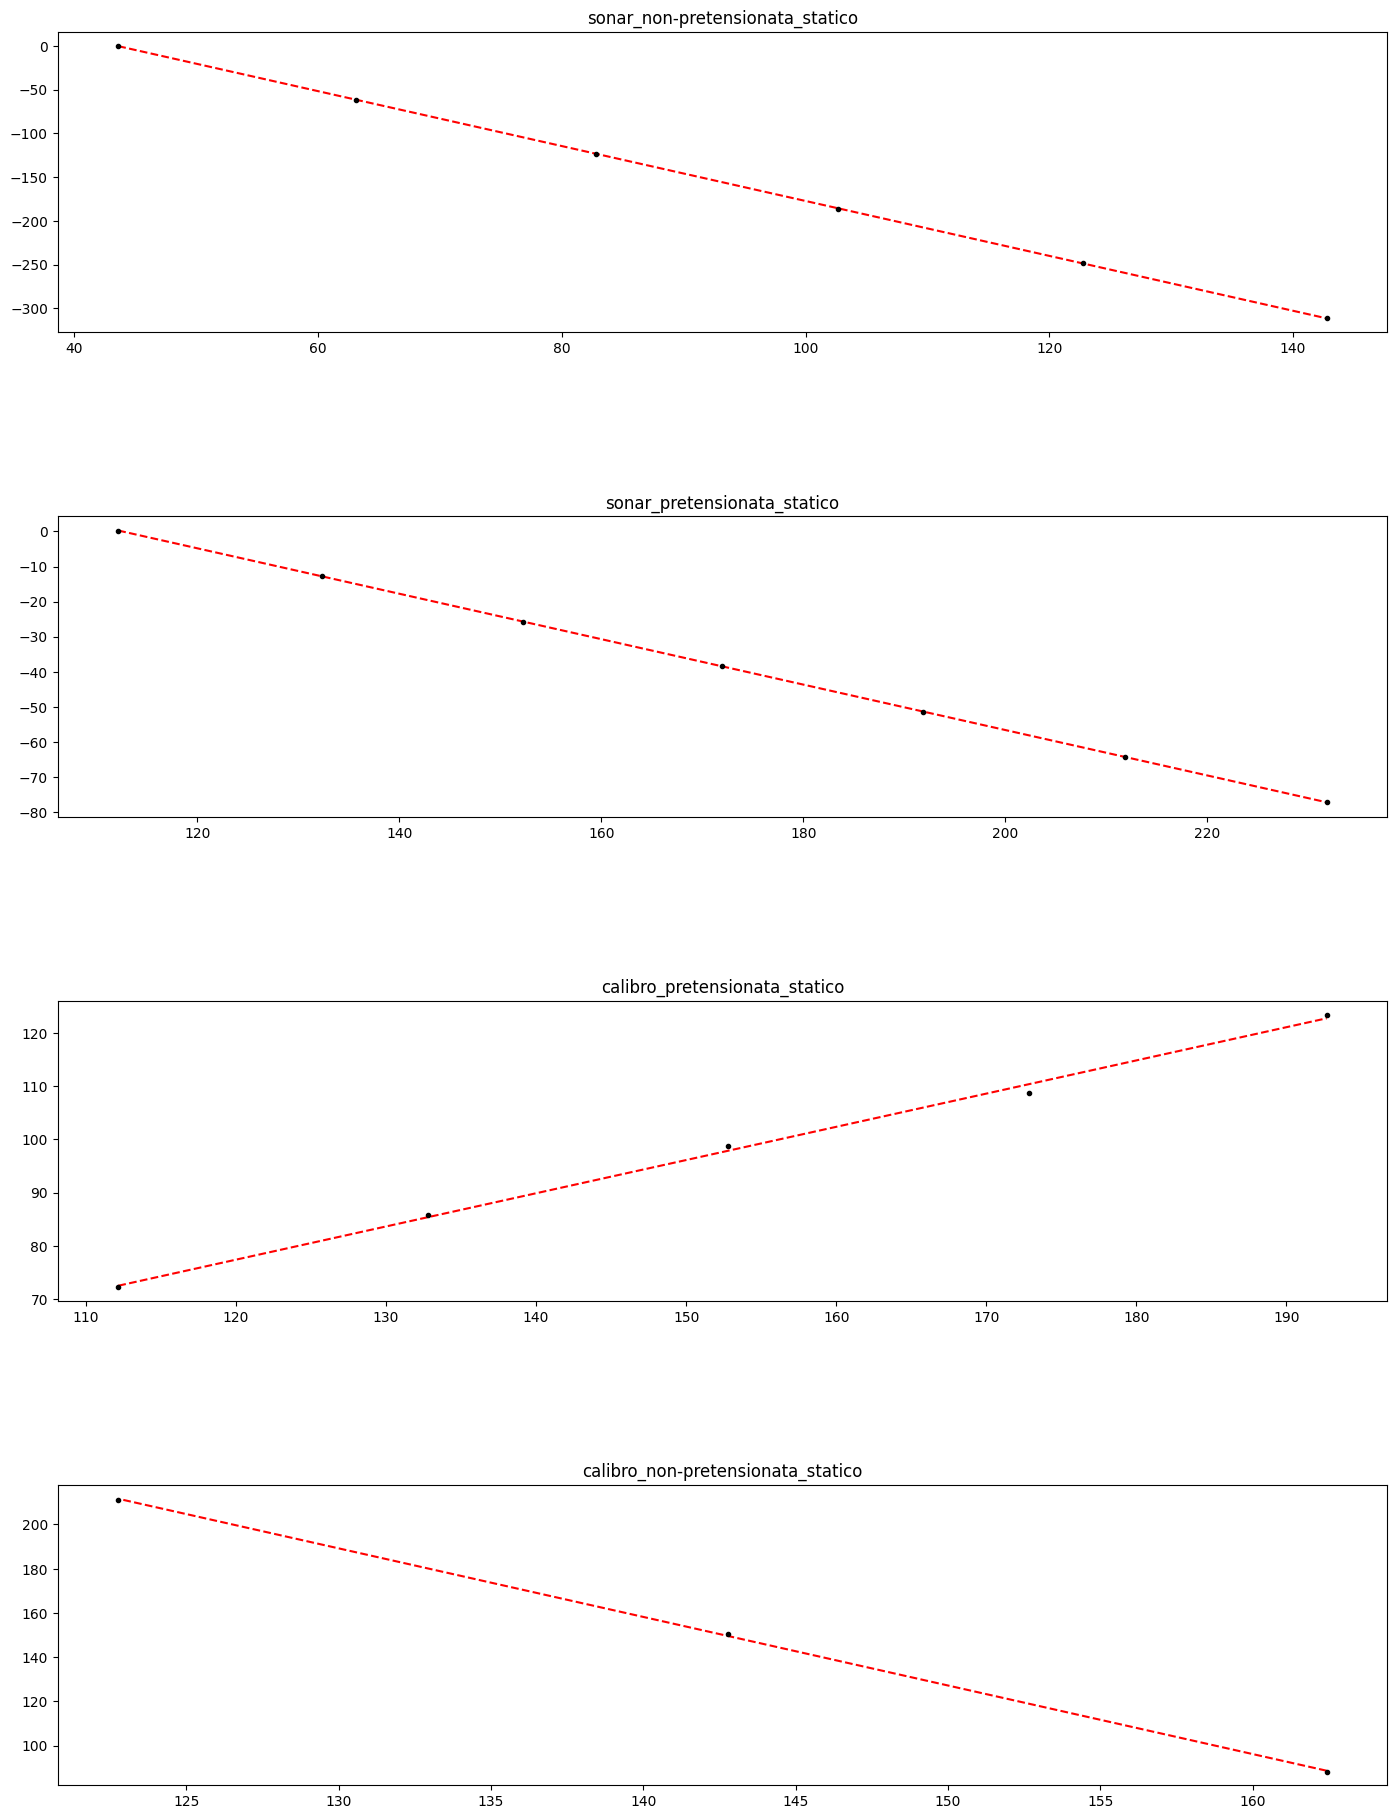

In [149]:
def analyze_calibre_data(dataset_name: str):
    used_spring = "molla " + list(
        filter(lambda e: "pretensionata" in e, dataset_name.split("_"))
    )[0].replace(
        "-", " "
    )  # ugly as hell solution
    used_masses = static_datasets[dataset_name].iloc[:, 0].array.tolist()
    mm_lengths = static_datasets[dataset_name].iloc[:, 1].array.tolist()
    in_lengths = static_datasets[dataset_name].iloc[:, 2].array.tolist()
    print(
        f"\nCALIBRE dataset: {dataset_name}\nspring: {used_spring}\nmasses: {used_masses}\nmm: {mm_lengths}\nin: {in_lengths}"
    )

    results = np.ndarray((len(used_masses), 4))

    for i in range(len(used_masses)):
        results[i] = [
            calculate_total_mass(used_masses[i], used_spring),
            mm_lengths[i],
            0.01,
            0.02,
        ]

    print(results, end="\n------------\n")
    return results


def analyze_sonar_data(dataset_name: str):
    runs = static_datasets[dataset_name]
    used_masses = static_datasets["masse_" + dataset_name].iloc[:, 0].array.tolist()
    used_spring = "molla " + list(
        filter(lambda e: "pretensionata" in e, dataset_name.split("_"))
    )[0].replace(
        "-", " "
    )  # ugly as hell solution
    print(
        f"\nSONAR dataset: {dataset_name}\nmasses: {used_masses}\nspring: {used_spring}"
    )

    results = np.ndarray((len(runs.columns), 4))

    i = 0
    for run_name in runs.columns:
        # print(runs[run_name].array)
        signal = runs[run_name]
        results[i] = [
            calculate_total_mass(used_masses[i], used_spring),
            np.mean(signal),
            0.01,
            0.2,
        ]
        i += 1

    print(results, end="\n------------\n")
    return results


def analyze_static_dataset(dataset_name: str):
    if "calibro" in dataset_name:
        return analyze_calibre_data(dataset_name)
    elif "sonar" in dataset_name:
        return analyze_sonar_data(dataset_name)


final_static_data = dict()

for key in filter(lambda e: not "masse" in e, static_datasets.keys()):
    final_static_data[key] = analyze_static_dataset(key)

print(f"\n~~~\n{final_static_data}\n~~~\n")

plot_results(final_static_data, PlotConfig(None, None, 4))

### Dynamic method

To approximate the period of the oscillation, two methods can be used:
- isolating the peaks of the wave function, calculate the mean of the periods between two adjacent peaks
- assuming the spring is oscillating following a damped armonic oscillator, we can fit the function `x(t) = A * exp(-gamma*t) * cos(w*t + phi)`

19
0.8230555555555554 0.1939960548755315


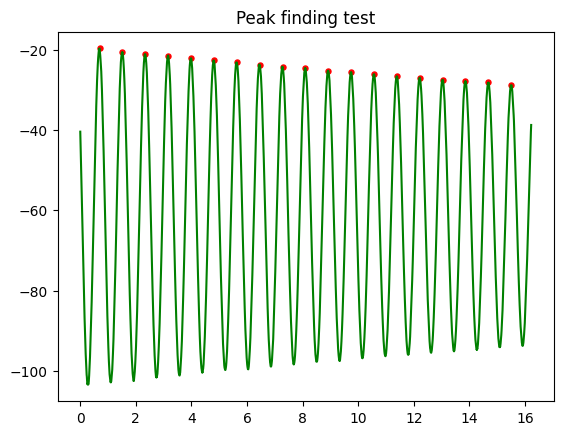

In [150]:
def my_find_peaks(signal: list):
    """
    |
    |           *               *    *              *
    |      *          *                   *    *
    | *                    *
    +-[---------^-----][--------^-----]------------------
               ptr1            ptr2
      / - - window1 - /
                      / - - window2 - /
    """

    peaks = []
    for i in range(5, len(signal) - 5, 5):
        window = signal[i - 5 : i + 5]  # it's [ i-2; i+2 ), i+2 is the length of window
        end_slopes = [window[1] - window[0], window[-1] - window[-2]]
        # the derivative can be 0 because it is guaranteed this only happens in the stationary points even on the signal
        if end_slopes[0] * end_slopes[1] <= 0 and (
            window[0] < signal[i] or signal[i] > window[-1]
        ):  # then we have a peak (and not a valley)
            if not i in peaks:
                peaks.append(i)
            if window[0] < -60:
                print(f"\n{i}: {window}\n------")

    return peaks


def calculate_mean_period(signal: list):
    peaks, _ = find_peaks(signal, width=10)
    mean = np.mean(signal)
    peaks = list(filter(lambda e: e >= mean, peaks))
    # print(f"{signal}\n{peaks}")

    acc_mean = 0
    for i in range(len(peaks) - 1):
        acc_mean += abs(peaks[i] - peaks[i + 1]) / dynamic_sampling_frequency
    mean = acc_mean / (len(peaks) - 1)

    acc_sigma = 0
    for i in range(len(peaks) - 1):
        acc_sigma += (
            abs((peaks[i] - peaks[i + 1]) / dynamic_sampling_frequency) - mean
        ) ** 2
    sigma = math.sqrt(acc_sigma / (len(peaks) - 1))

    return (mean, sigma / math.sqrt(len(peaks)))


# test run:
_signal = dynamic_datasets["sonar_non-pretensionata_dinamico"].iloc[:, 0].array.tolist()
_peaks, _ = find_peaks(_signal, width=10)
_mean = np.mean(_signal)
_peaks = list(filter(lambda e: e >= _mean, _peaks))

print(len(_peaks))

plt.title("Peak finding test")
plt.plot([i / dynamic_sampling_frequency for i in range(len(_signal))], _signal, c="g")
plt.scatter(
    [x / dynamic_sampling_frequency for x in _peaks],
    [_signal[x] for x in _peaks],
    c="r",
    s=13,
)

_acc = 0
for i in range(len(_peaks) - 1):
    _acc += abs(_peaks[i] - _peaks[i + 1]) / dynamic_sampling_frequency
_mean = _acc / (len(_peaks) - 1)

print(_mean, _mean / math.sqrt(len(_peaks) - 1))

del _signal
del _peaks
del _mean
del _acc
del _


SONAR dataset: sonar_non-pretensionata_dinamico
masses: ['na', '1', '1,2', '1,2,3', '1,2,3,4', '1,2,3,4,5']
spring: molla non pretensionata

SONAR dataset: sonar_pretensionata_dinamico
masses: ['1,2,3', '1,2,3,4', '1,2,3,4,5', '1,2,3,4,5,6', '1,2,3,4,5,6,7', '1,2,3,4,5,6,7,8', '1,2,3,4,5,6,7,8,9']
spring: molla pretensionata

~~~
{'sonar_non-pretensionata_dinamico': array([[4.36100000e+01, 6.55869565e-01, 1.00000000e-02, 8.85274763e-04],
       [6.31500000e+01, 8.23055556e-01, 1.00000000e-02, 1.02530035e-03],
       [8.27800000e+01, 9.61562500e-01, 1.00000000e-02, 1.05945693e-03],
       [1.02640000e+02, 1.08214286e+00, 1.00000000e-02, 1.15589570e-03],
       [1.22770000e+02, 1.19115385e+00, 1.00000000e-02, 1.97190752e-03]]), 'sonar_pretensionata_dinamico': array([[1.12160000e+02, 5.18421053e-01, 1.00000000e-02, 9.85281924e-04],
       [1.32290000e+02, 5.93235294e-01, 1.00000000e-02, 3.49006527e-03],
       [1.52280000e+02, 6.32666667e-01, 1.00000000e-02, 6.12788874e-03],
       [1.71

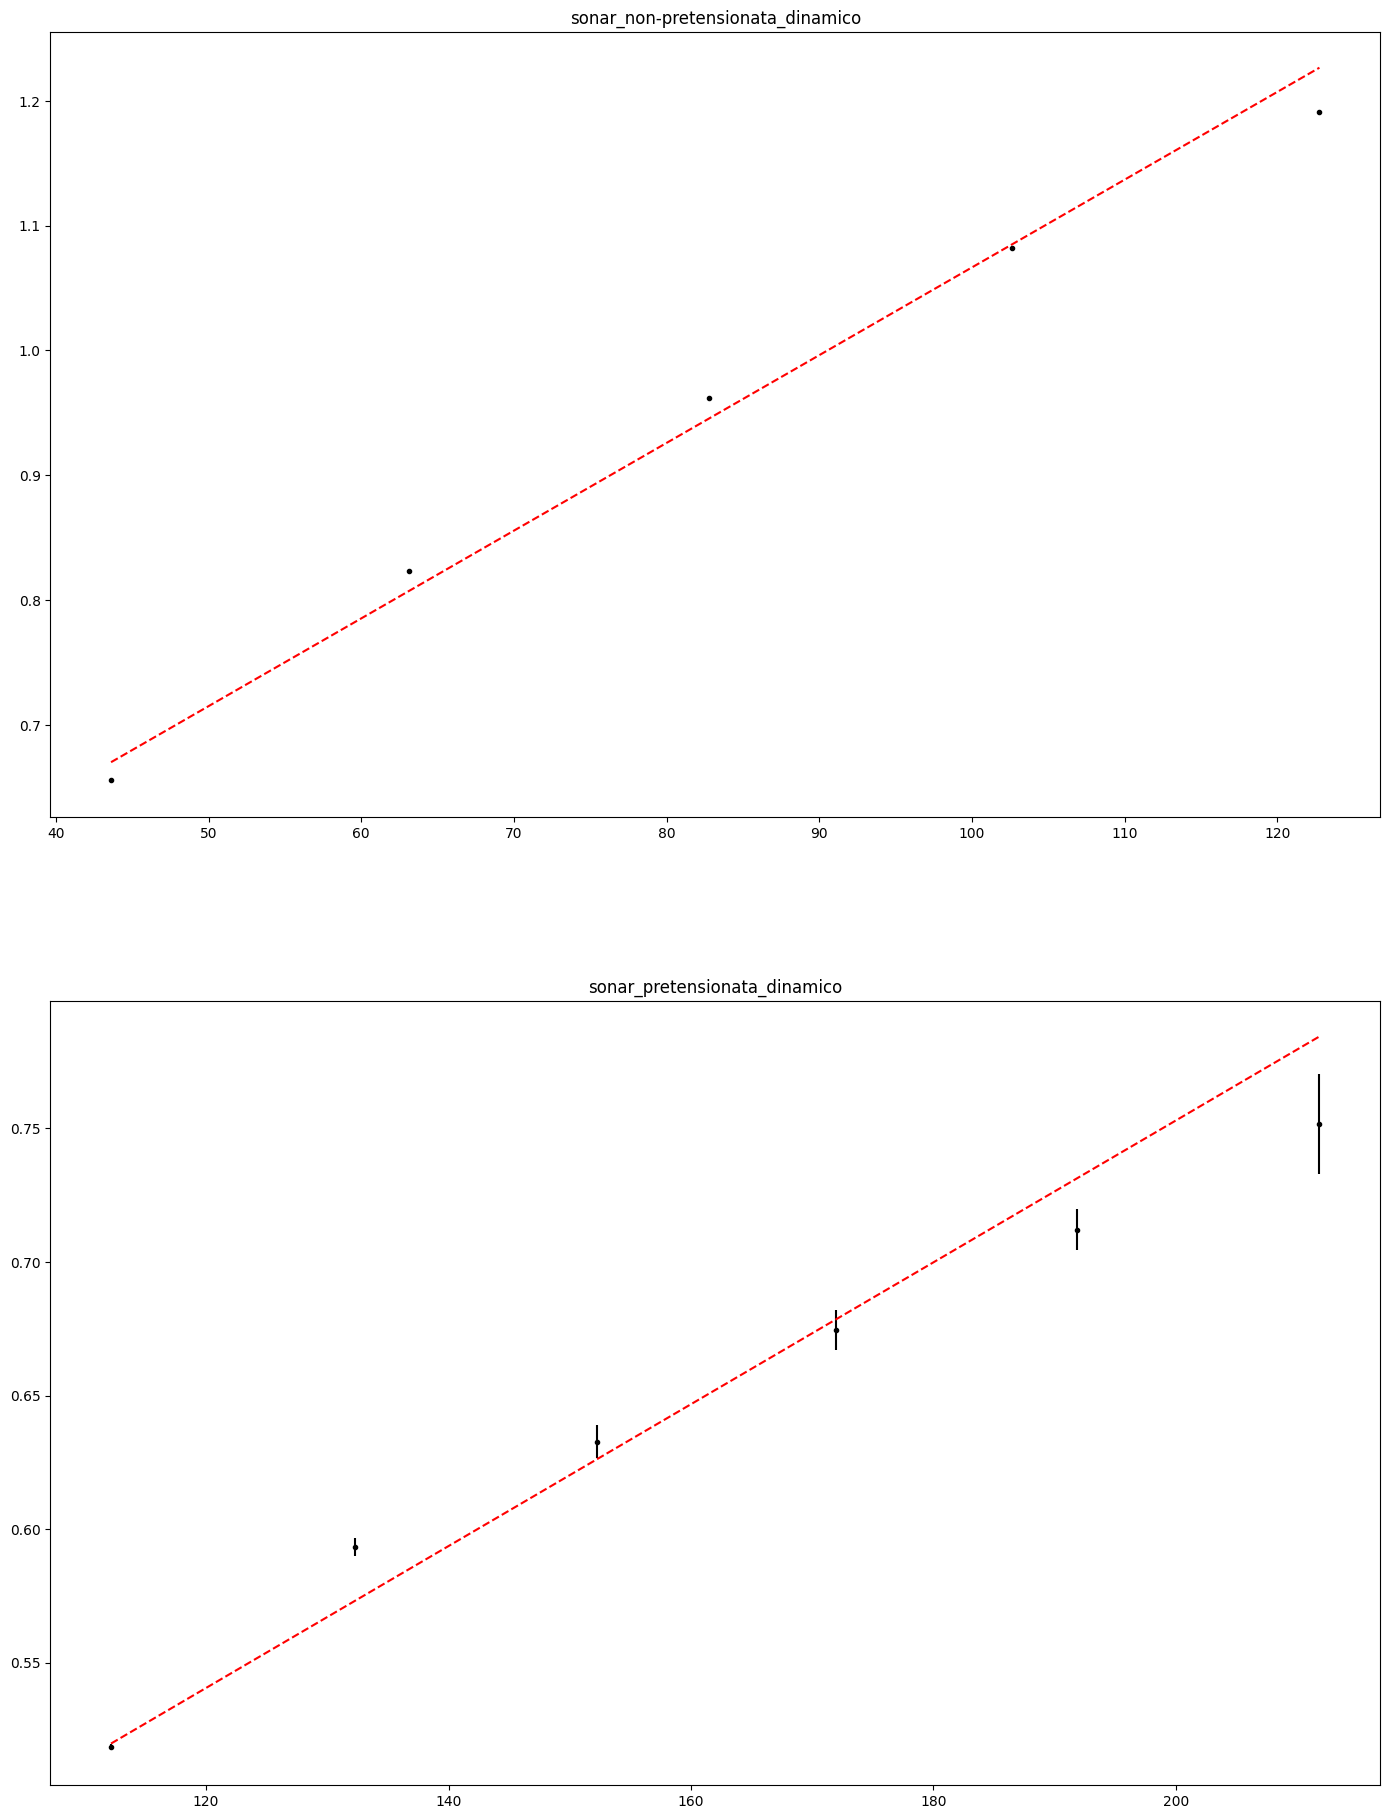

In [151]:
# redefinition of analyze_dataset()... python you are a criminal
def analyze_dynamic_dataset(dataset_name: str):
    used_spring = "molla " + list(
        filter(lambda e: "pretensionata" in e, dataset_name.split("_"))
    )[0].replace(
        "-", " "
    )  # ugly as hell solution
    used_masses = dynamic_datasets["masse_" + dataset_name].iloc[:, 0].array.tolist()
    used_masses = [str(s) for s in used_masses]
    runs = dynamic_datasets[dataset_name]
    print(
        f"\nSONAR dataset: {dataset_name}\nmasses: {used_masses}\nspring: {used_spring}"
    )

    results = np.ndarray((len(runs.columns), 4))

    i = 0
    for run_name in runs.columns:
        signal = runs[run_name].array.tolist()

        mean_period, sigma_mean_period = calculate_mean_period(signal)

        results[i] = [
            calculate_total_mass(used_masses[i], used_spring),
            mean_period,
            0.01,
            sigma_mean_period,
        ]
        i += 1

    # results = np.ndarray(sorted(results.tolist(), key=lambda e: e[0]))
    results = np.sort(results, 0)

    return results


final_dynamic_data = dict()

for key in filter(lambda e: not "masse" in e, dynamic_datasets.keys()):
    final_dynamic_data[key] = analyze_dynamic_dataset(key)

print(f"\n~~~\n{final_dynamic_data}\n~~~\n")  # the period looks way too short

plot_results(final_dynamic_data, PlotConfig(None, None, 2))